# Autoencoder untuk Klasifikasi Binary

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

from sklearn.manifold import TSNE
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

2025-11-15 11:55:22.918079: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-15 11:55:23.029908: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763182523.051176  363557 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763182523.061629  363557 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-15 11:55:23.181046: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## 1. Preprocessing

In [4]:
(x_train_full, y_train_full), (x_test_full, y_test_full) = fashion_mnist.load_data()
print("Data asli dimuat:")
print(f"x_train_full shape: {x_train_full.shape}")
print(f"x_test_full shape: {x_test_full.shape}")

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Data asli dimuat:
x_train_full shape: (60000, 28, 28)
x_test_full shape: (10000, 28, 28)


Digunakan dataset pakaian dari MNIST sekedar sebagai data citra. Lalu kelas 1 akan dijadikan sebagai "normal" dan kelas 9 akan dijadikan sebagai "anomali" agar membentuk sebuah klasifikasi biner.

In [5]:
NORMAL_CLASS = 1  # 'Trouser' akan menjadi data normal
ANOMALY_CLASS = 9 # 'Ankle boot' akan menjadi data anomali/cacat

In [6]:
x_train = x_train_full[y_train_full == NORMAL_CLASS]

In [7]:
x_test_normal = x_test_full[y_test_full == NORMAL_CLASS]
x_test_anomaly = x_test_full[y_test_full == ANOMALY_CLASS]
x_test = np.vstack((x_test_normal, x_test_anomaly))

In [8]:
y_test = np.concatenate((
    np.zeros(len(x_test_normal), dtype=int),
    np.ones(len(x_test_anomaly), dtype=int)
))

In [9]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [10]:
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

In [11]:
print("\nBentuk data setelah diproses:")
print(f"Training data (x_train):   {x_train.shape}")
print(f"Test data (x_test):        {x_test.shape}")
print(f"Test labels (y_test):      {y_test.shape}")
print(f"Jumlah data normal di set tes: {len(x_test_normal)}")
print(f"Jumlah data anomali di set tes: {len(x_test_anomaly)}")


Bentuk data setelah diproses:
Training data (x_train):   (6000, 28, 28, 1)
Test data (x_test):        (2000, 28, 28, 1)
Test labels (y_test):      (2000,)
Jumlah data normal di set tes: 1000
Jumlah data anomali di set tes: 1000



Contoh data normal (untuk training):


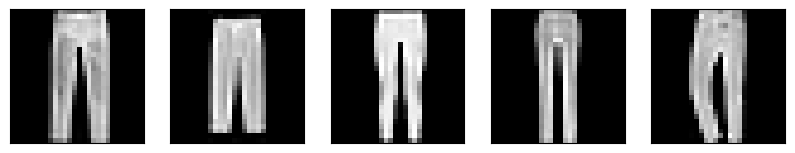

In [12]:
print("\nContoh data normal (untuk training):")
plt.figure(figsize=(10, 2))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


Contoh data anomali (dari test set):


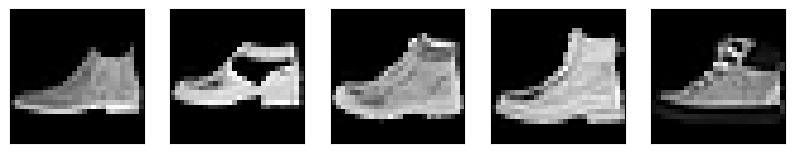

In [13]:
print("\nContoh data anomali (dari test set):")
plt.figure(figsize=(10, 2))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(x_test_anomaly[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 2. Modeling Autoencoder

**Encoder**: Bagian ini akan mengompresi gambar input `28x28` menjadi representasi laten (vektor fitur) yang jauh lebih kecil. Akan digunakan lapisan `Conv2D` untuk ekstraksi fitur dan MaxPooling2D untuk mengurangi dimensi gambar.

**Decoder**: Bagian ini akan mencoba merekonstruksi gambar `28x28` asli dari representasi laten yang dikompresi. Akan digunakan lapisan `Conv2DTranspose` dan `UpSampling2D` untuk memperbesar kembali dimensinya.

In [15]:

class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(28, 28, 1)),
            # 28x28x1 -> 14x14x16
            layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
            # 14x14x16 -> 7x7x8
            layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)
        ])
        
        # Decoder
        self.decoder = tf.keras.Sequential([
            # 7x7x8 -> 14x14x16
            layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
            # 14x14x16 -> 28x28x1
            layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
            # Output layer
            layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AnomalyDetector()

autoencoder.compile(optimizer='adam', loss='mae')

I0000 00:00:1763182990.130479  363557 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13689 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


In [18]:
history = autoencoder.fit(
    x_train,          
    x_train,          
    epochs=25,        
    batch_size=64,
    shuffle=True,
    validation_split=0.1 
)

Epoch 1/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0314 - val_loss: 0.0307
Epoch 2/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0300 - val_loss: 0.0290
Epoch 3/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0285 - val_loss: 0.0277
Epoch 4/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0274 - val_loss: 0.0270
Epoch 5/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0263 - val_loss: 0.0260
Epoch 6/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0254 - val_loss: 0.0249
Epoch 7/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0249 - val_loss: 0.0241
Epoch 8/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0240 - val_loss: 0.0238
Epoch 9/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0235 - val_loss: 0.0231
Epoch 10/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0228 - val_loss: 0.0230
Epoch 11/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0227 - val_loss: 0.0225
Epoch 12/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0222 - val_l

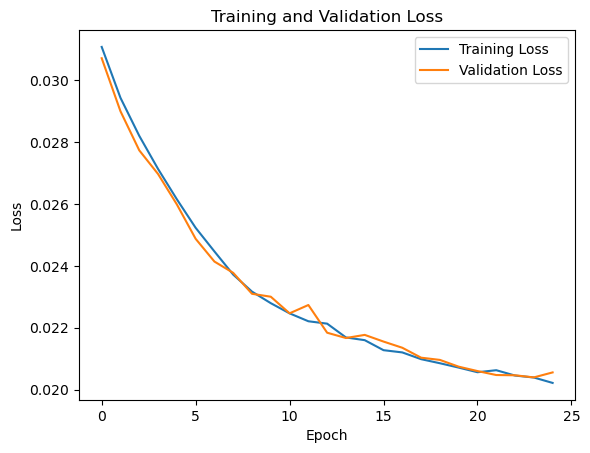

In [21]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## 3a. Anomali detektor

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


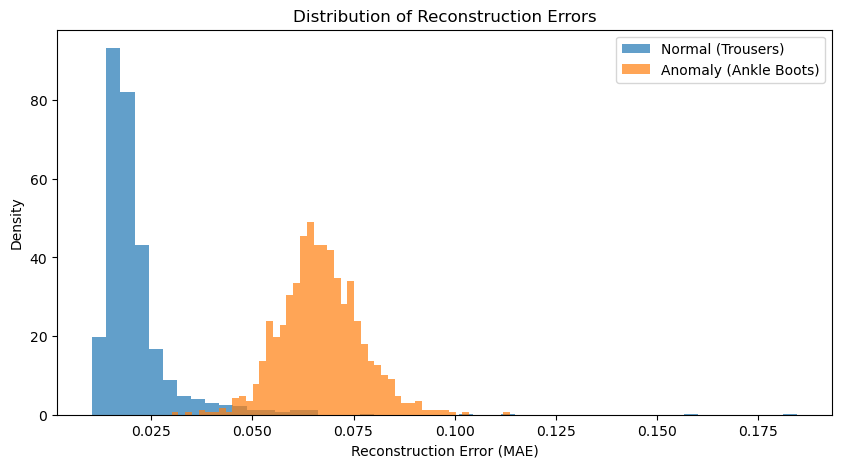

In [22]:
reconstructions = autoencoder.predict(x_test)
test_loss = tf.keras.losses.mae(reconstructions, x_test)
test_loss = np.mean(test_loss, axis=(1, 2))
loss_normal = test_loss[y_test == 0]
loss_anomaly = test_loss[y_test == 1]

plt.figure(figsize=(10, 5))
plt.hist(loss_normal, bins=50, density=True, label='Normal (Trousers)', alpha=0.7)
plt.hist(loss_anomaly, bins=50, density=True, label='Anomaly (Ankle Boots)', alpha=0.7)
plt.xlabel("Reconstruction Error (MAE)")
plt.ylabel("Density")
plt.title("Distribution of Reconstruction Errors")
plt.legend()
plt.show()


Threshold yang dihitung: 0.05509
Garis vertikal pada plot di atas menunjukkan threshold ini.


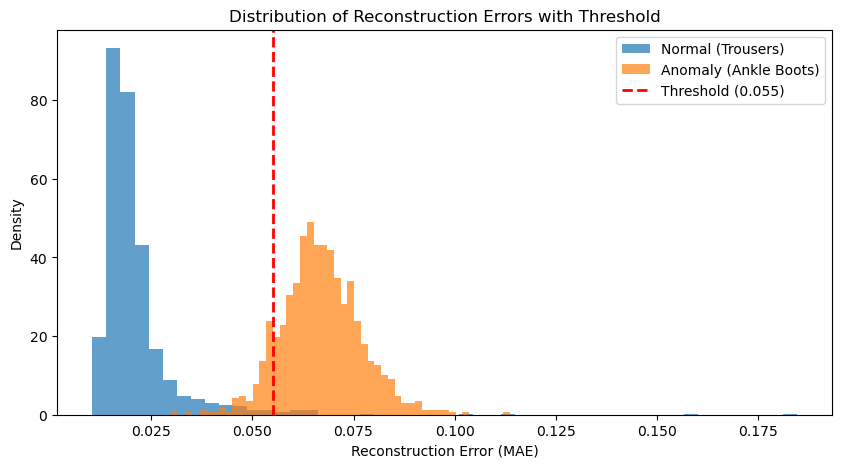

In [23]:
threshold = np.mean(loss_normal) + 3 * np.std(loss_normal)
print(f"\nThreshold yang dihitung: {threshold:.5f}")
print("Garis vertikal pada plot di atas menunjukkan threshold ini.")

plt.figure(figsize=(10, 5))
plt.hist(loss_normal, bins=50, density=True, label='Normal (Trousers)', alpha=0.7)
plt.hist(loss_anomaly, bins=50, density=True, label='Anomaly (Ankle Boots)', alpha=0.7)
plt.axvline(threshold, color='r', linestyle='--', linewidth=2, label=f'Threshold ({threshold:.3f})')
plt.xlabel("Reconstruction Error (MAE)")
plt.ylabel("Density")
plt.title("Distribution of Reconstruction Errors with Threshold")
plt.legend()
plt.show()


Membandingkan gambar asli vs. hasil rekonstruksi:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


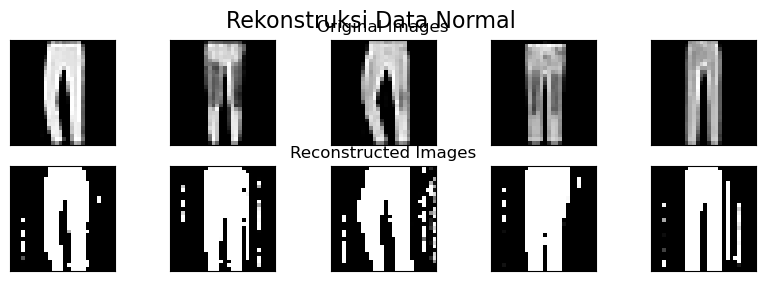

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


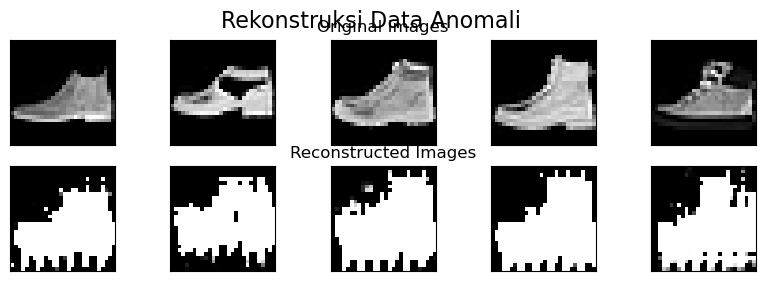

In [24]:

def plot_reconstructions(model, images, n_images=5, title=""):
    reconstructions = model.predict(images[:n_images])
    plt.figure(figsize=(10, 3))
    plt.suptitle(title, fontsize=16)
    for i in range(n_images):
        # Plot asli
        ax = plt.subplot(2, n_images, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n_images // 2: ax.set_title("Original Images")

        # Plot rekonstruksi
        ax = plt.subplot(2, n_images, i + 1 + n_images)
        plt.imshow(reconstructions[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n_images // 2: ax.set_title("Reconstructed Images")
    plt.show()

print("\nMembandingkan gambar asli vs. hasil rekonstruksi:")
plot_reconstructions(autoencoder, x_test_normal, title="Rekonstruksi Data Normal")

plot_reconstructions(autoencoder, x_test_anomaly, title="Rekonstruksi Data Anomali")

## 3b. Fitur ekstraktor

In [25]:
encoder = autoencoder.encoder
print("Ringkasan Arsitektur Encoder:")
encoder.summary()

x_test_features = encoder.predict(x_test)
print(f"\nBentuk asli data uji: {x_test.shape}")
print(f"Bentuk fitur setelah diekstrak (latent space): {x_test_features.shape}")


Ringkasan Arsitektur Encoder:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 8)        │         1,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,320 (5.16 KB)

 Trainable params: 1,320 (5.16 KB)

 Non-trainable params: 0 (0.00 B)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Bentuk asli data uji: (2000, 28, 28, 1)
Bentuk fitur setelah diekstrak (latent space): (2000, 7, 7, 8)


In [26]:

train_normal_idx = np.where(y_train_full == NORMAL_CLASS)[0]
train_anomaly_idx = np.where(y_train_full == ANOMALY_CLASS)[0]

train_idx = np.concatenate((train_normal_idx, train_anomaly_idx))
np.random.shuffle(train_idx)

x_train_classifier = x_train_full[train_idx]
y_train_classifier = (y_train_full[train_idx] == ANOMALY_CLASS).astype(int) 

x_train_classifier = (x_train_classifier.astype('float32') / 255.0)
x_train_classifier = np.expand_dims(x_train_classifier, axis=-1)

x_train_features = encoder.predict(x_train_classifier)


375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [27]:

classifier = tf.keras.Sequential([
    layers.Input(shape=x_train_features.shape[1:]),
    layers.Flatten(),
    layers.Dense(20, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(1, activation='sigmoid') 
])

classifier.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

classifier_history = classifier.fit(
    x_train_features,
    y_train_classifier,
    epochs=10,
    batch_size=128,
    validation_data=(x_test_features, y_test),
    shuffle=True,
    verbose=1 
)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9605 - loss: 0.1140 - val_accuracy: 0.9995 - val_loss: 0.0036
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9994 - loss: 0.0035 - val_accuracy: 0.9990 - val_loss: 0.0041
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9996 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 0.0010
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9997 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 7.5582e-04
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9998 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 5.3319e-04
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9998 - loss: 7.5636e-04 - val_accuracy: 1.0000 - val_loss: 8.0269e-04
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9998 - loss: 8.6776e-04 - val_accuracy: 1.0000 - val_loss: 3.4735e-04
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 6.5325e-04 - val

Memvisualisasikan histori pelatihan classifier...


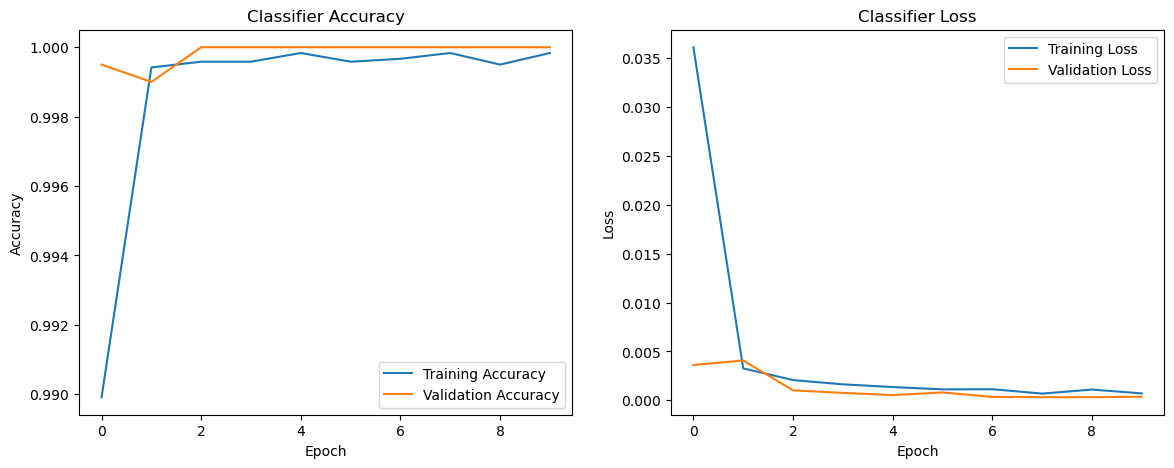

In [31]:

print("Memvisualisasikan histori pelatihan classifier...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(classifier_history.history['accuracy'], label='Training Accuracy')
ax1.plot(classifier_history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Classifier Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax2.plot(classifier_history.history['loss'], label='Training Loss')
ax2.plot(classifier_history.history['val_loss'], label='Validation Loss')
ax2.set_title('Classifier Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()


Membuat visualisasi t-SNE dari ruang laten (mungkin perlu beberapa saat)...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...


/home/hamim/miniforge3/envs/autoencoder_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 2000 samples in 0.318s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 3.829723
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.518326
[t-SNE] KL divergence after 300 iterations: 1.499910


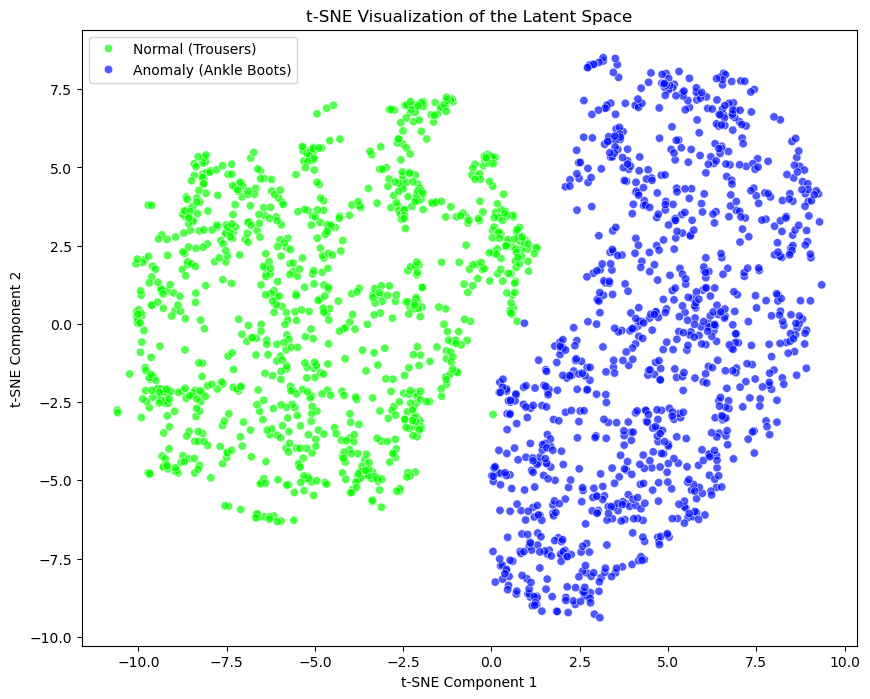

In [32]:

print("\nMembuat visualisasi t-SNE dari ruang laten (mungkin perlu beberapa saat)...")

latent_space_flat = x_test_features.reshape(x_test_features.shape[0], -1)

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(latent_space_flat)

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=y_test, # Beri warna berdasarkan label asli (0 atau 1)
    palette=sns.color_palette("hsv", 2),
    legend="full",
    alpha=0.7
)
plt.title('t-SNE Visualization of the Latent Space')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, ['Normal (Trousers)', 'Anomaly (Ankle Boots)'])
plt.show()

## 4. Evaluasi

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

           Evaluasi Metode A: Anomaly Detector

Laporan Klasifikasi:
              precision    recall  f1-score   support

      Normal       0.90      0.98      0.94      1000
     Anomaly       0.98      0.89      0.94      1000

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000



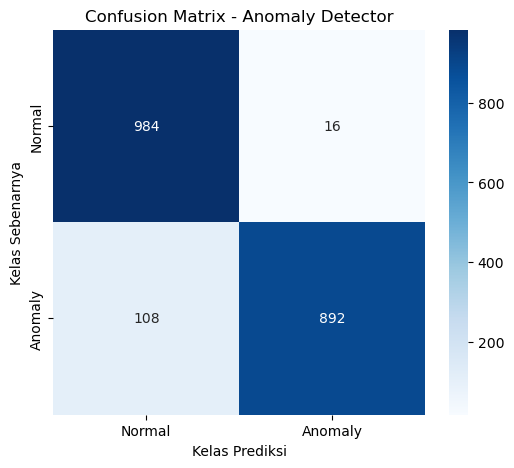

In [34]:
preds_anomaly_detector = (test_loss > threshold).astype(int)
probs_anomaly_detector = test_loss 
probs_classifier = classifier.predict(x_test_features).ravel()
preds_classifier = (probs_classifier > 0.5).astype(int)


print("\n" + "="*57)
print("           Evaluasi Metode A: Anomaly Detector")
print("\n" + "="*57)

print("Laporan Klasifikasi:")
print(classification_report(y_test, preds_anomaly_detector, target_names=['Normal', 'Anomaly']))

cm_ad = confusion_matrix(y_test, preds_anomaly_detector)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_ad, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix - Anomaly Detector')
plt.ylabel('Kelas Sebenarnya')
plt.xlabel('Kelas Prediksi')
plt.show()




     Evaluasi Metode B: Feature Extractor + Classifier
Laporan Klasifikasi:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      1000
     Anomaly       1.00      1.00      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



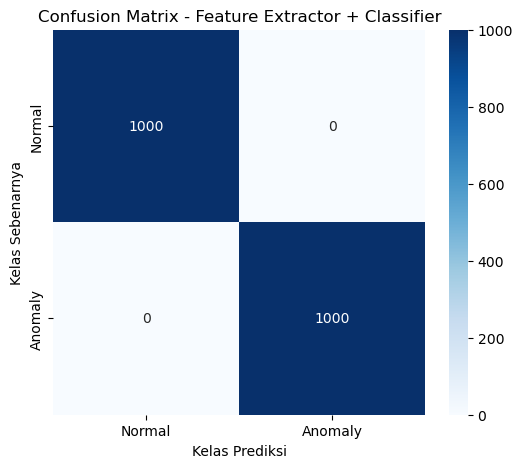

In [35]:

print("\n" + "="*57)
print("     Evaluasi Metode B: Feature Extractor + Classifier")
print("="*57)

print("Laporan Klasifikasi:")
print(classification_report(y_test, preds_classifier, target_names=['Normal', 'Anomaly']))

cm_fc = confusion_matrix(y_test, preds_classifier)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_fc, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix - Feature Extractor + Classifier')
plt.ylabel('Kelas Sebenarnya')
plt.xlabel('Kelas Prediksi')
plt.show()




             Perbandingan Kurva ROC & Skor AUC


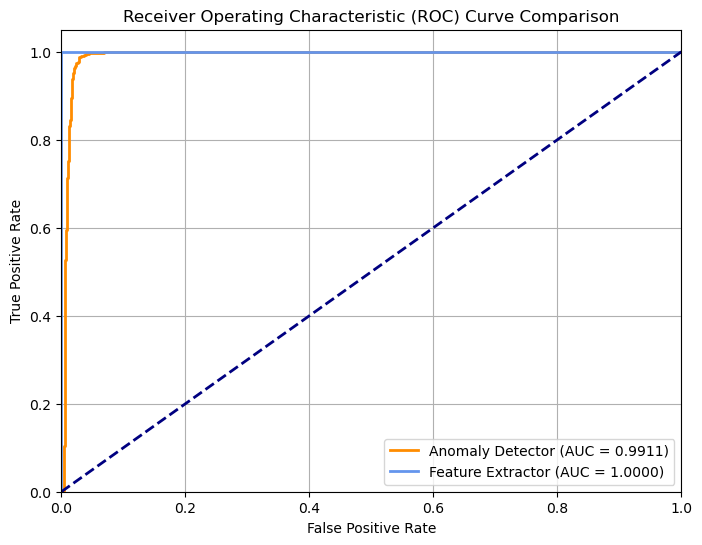

In [36]:

# FPR, TPR untuk kedua model
fpr_ad, tpr_ad, _ = roc_curve(y_test, probs_anomaly_detector)
roc_auc_ad = auc(fpr_ad, tpr_ad)

fpr_fc, tpr_fc, _ = roc_curve(y_test, probs_classifier)
roc_auc_fc = auc(fpr_fc, tpr_fc)

print("\n" + "="*57)
print("             Perbandingan Kurva ROC & Skor AUC")
print("="*57)
plt.figure(figsize=(8, 6))
plt.plot(fpr_ad, tpr_ad, color='darkorange', lw=2, label=f'Anomaly Detector (AUC = {roc_auc_ad:.4f})')
plt.plot(fpr_fc, tpr_fc, color='cornflowerblue', lw=2, label=f'Feature Extractor (AUC = {roc_auc_fc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Berdasarkan hasil evaluasi, pendekatan Fitur ekstraksi dengan sebuah klasifier secara signifikan lebih unggul dan mencapai performa yang sempurna dibandingkan dengan pendekatan Anomali detektor.

**Fitur Ekstraktor + Klasifier** mencapai performa sempurna dengan akurasi 100%. Keberhasilan ini disebabkan oleh kemampuan encoder dalam menciptakan representasi fitur (latent space) yang sangat informatif, sehingga classifier dapat memisahkan kedua kelas tanpa kesalahan.

**Anomaly Detector** menunjukkan kinerja yang baik dengan akurasi 94%, namun memiliki kelemahan signifikan. Model ini menghasilkan 108 False Negatives, di mana anomali gagal terdeteksi. Kegagalan ini merupakan jenis kesalahan yang paling kritis dalam skenario deteksi cacat.

Kesimpulannya, untuk tugas klasifikasi biner di mana data berlabel dari kedua kelas tersedia, metode Fitur Ekstraktor + Klasifier adalah pilihan yang lebih kuat dan presisi. Pendekatan Anomali Detektor lebih cocok untuk skenario unsupervised di mana contoh anomali tidak diketahui sebelumnya.